# Model Training

This notebook holds a proof of concept of how the CreditKarma Scorer model would be trained using the gold table. CreditKarma Scorer is a binary classification logistic regression model that outputs the **probability of a customer defaulting their loan**. Loaning decisions are made by setting a threshold probability based on **F1.5-score**, as we want to be conservative in giving out loans and prioritize low-risk individuals (i.e. minimize false negatives from CreditKarma Scorer, which rates a high risk individual as low risk).

In [18]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from tqdm import tqdm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import pickle
import joblib

import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient

# Data Preprocessing

**Import data from gold table**

In [19]:
spark = pyspark.sql.SparkSession.builder \
    .appName("model-training") \
    .master("local[*]") \
    .getOrCreate()

In [29]:
def read_gold_table(table, gold_db, spark):
    """
    Helper function to read all partitions of a gold table
    """
    folder_path = os.path.join(gold_db, table)
    files_list = [os.path.join(folder_path, os.path.basename(f)) for f in glob.glob(os.path.join(folder_path, '*'))]
    df = spark.read.option("header", "true").option("mergeSchema", "true").parquet(*files_list)
    return df


In [30]:
X_spark = read_gold_table('feature_store', 'datamart/gold', spark)
y_spark = read_gold_table('label_store', 'datamart/gold', spark)

In [31]:
X_df = X_spark.toPandas().sort_values(by='customer_id')
y_df = y_spark.toPandas().sort_values(by='customer_id')

In [32]:
X_df

,customer_id,snapshot_date,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,payment_of_min_amount_no,payment_of_min_amount_nm,credit_mix_standard,credit_mix_good,credit_mix_bad,payment_behaviour_spent_low,payment_behaviour_spent_high,payment_behaviour_value_small,payment_behaviour_value_medium,payment_behaviour_value_large
1705,CUS_0x1000,2023-05-01,18.0,30625.939453,2706.161621,6.0,5.0,27.0,2.0,57.0,...,0,0,0,0,1,0,1,0,1,0
30,CUS_0x100b,2024-03-01,19.0,113781.390625,9549.782227,1.0,4.0,1.0,0.0,14.0,...,1,0,0,1,0,0,1,1,0,0
1449,CUS_0x1011,2023-11-01,44.0,58918.468750,5208.872559,3.0,3.0,17.0,3.0,27.0,...,0,0,1,0,0,1,0,0,1,0
5286,CUS_0x1013,2023-12-01,44.0,98620.976562,7962.415039,3.0,3.0,6.0,3.0,12.0,...,1,0,0,1,0,0,1,0,1,0
6347,CUS_0x1015,2023-08-01,27.0,46951.019531,3725.584961,7.0,4.0,16.0,0.0,8.0,...,0,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586,CUS_0xfe5,2023-06-01,38.0,96960.210938,7934.017578,6.0,4.0,8.0,0.0,24.0,...,1,0,1,0,0,0,1,0,0,1
4072,CUS_0xfea,2023-10-01,33.0,44264.410156,3755.700928,3.0,3.0,6.0,2.0,11.0,...,1,0,0,1,0,1,0,1,0,0
4899,CUS_0xff3,2024-06-01,55.0,17032.785156,1176.398804,0.0,6.0,2.0,3.0,13.0,...,1,0,0,1,0,1,0,1,0,0
2187,CUS_0xffc,2024-01-01,18.0,60877.171875,5218.097656,6.0,8.0,27.0,8.0,46.0,...,0,0,0,0,0,0,1,0,0,1


**Set train test split**

In [34]:
model_train_date_str = "2024-09-01" # pretend we're training the model at this time
train_test_period_months = 12
oot_period_months = 2
train_valtest_ratio = 0.2
val_test_ratio = 0.5

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d").date()
config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_valtest_ratio"] = train_valtest_ratio 
config["val_test_ratio"] = val_test_ratio

config

{'model_train_date_str': '2024-09-01',
 'train_test_period_months': 12,
 'oot_period_months': 2,
 'model_train_date': datetime.date(2024, 9, 1),
 'oot_end_date': datetime.date(2024, 8, 31),
 'oot_start_date': datetime.date(2024, 7, 1),
 'train_test_end_date': datetime.date(2024, 6, 30),
 'train_test_start_date': datetime.date(2023, 7, 1),
 'train_valtest_ratio': 0.2,
 'val_test_ratio': 0.5}

Split OOT

In [35]:
# Consider data from model training date
y_model_df = y_df[(y_df['snapshot_date'] >= config['train_test_start_date']) & (y_df['snapshot_date'] <= config['model_train_date'])]
X_model_df = X_df[np.isin(X_df['customer_id'], y_model_df['customer_id'].unique())]

# Create OOT split
y_oot = y_model_df[(y_model_df['snapshot_date'] >= config['oot_start_date']) & (y_model_df['snapshot_date'] <= config['oot_end_date'])]
X_oot = X_model_df[np.isin(X_model_df['customer_id'], y_oot['customer_id'].unique())]

# Everything else goes into train-test
y_trainvaltest = y_model_df[y_model_df['snapshot_date'] <= config['train_test_end_date']]
X_trainvaltest = X_model_df[np.isin(X_model_df['customer_id'], y_trainvaltest['customer_id'].unique())]

Split train-test

In [36]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X_trainvaltest, y_trainvaltest, 
                                                    test_size=config['train_valtest_ratio'], 
                                                    random_state=611, 
                                                    shuffle=True, 
                                                    stratify=y_trainvaltest['label'])

X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, 
                                                    test_size=config['val_test_ratio'], 
                                                    random_state=611, 
                                                    shuffle=True, 
                                                    stratify=y_valtest['label'])

In [37]:
# Transform data into numpy arrays
X_train_arr = X_train.drop(columns=['customer_id', 'snapshot_date']).values
X_val_arr = X_val.drop(columns=['customer_id', 'snapshot_date']).values
X_test_arr = X_test.drop(columns=['customer_id', 'snapshot_date']).values
X_oot_arr = X_oot.drop(columns=['customer_id', 'snapshot_date']).values

y_train_arr = y_train['label'].values
y_val_arr = y_val['label'].values
y_test_arr = y_test['label'].values
y_oot_arr = y_oot['label'].values

Data Preprocessing Pipeline

In [38]:
preprocessing_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

X_train_arr = preprocessing_pipeline.fit_transform(X_train_arr)
X_val_arr = preprocessing_pipeline.transform(X_val_arr)
X_test_arr = preprocessing_pipeline.transform(X_test_arr)
X_oot_arr = preprocessing_pipeline.transform(X_oot_arr)

# artifact_tmp_path = f'artifact_bank/{config['model_train_date_str']}'
# os.makedirs(artifact_tmp_path, exist_ok=True)
# joblib.dump(preprocessing_pipeline, f"{artifact_tmp_path}/preprocessing_pipeline.pkl")

Normalize data

# Train CreditKarma Scorer

In [39]:
param_grid = {
    'penalty':['l1','l2','elasticnet', None],
    'C' : [0.01, 0.1, 1, 10],
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter': [200]
}

valid_combinations = {
    'liblinear': ['l1', 'l2'],
    'lbfgs': ['l2', None],
    'newton-cg': ['l2', None],
    'sag': ['l2', None],
    'saga': ['l1', 'l2', 'elasticnet', None],
}

In [40]:
best_score = -np.inf
clf = None
best_params = {}

for solver, penalty, C, max_iter in itertools.product(param_grid['solver'], param_grid['penalty'], param_grid['C'], param_grid['max_iter']):
    # if penalty not in valid_combinations.get(solver, []):
    #     continue  # skip invalid combo
    try:
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter)
        model.fit(X_train_arr, y_train_arr)
        val_preds = model.predict_proba(X_val_arr)[:, 1]
        score = roc_auc_score(y_val_arr, val_preds)
        
        print(f"Evaluated C={C}, penalty={penalty}, solver={solver} -> val_auc={score:.4f}")

        if score > best_score:
            best_score = score
            clf = model
            best_params = {'C': C, 'penalty': penalty, 'solver': solver}
    except Exception as e:
        # print(f"Skipped C={C}, penalty={penalty}, solver={solver}: {e}")
        continue

# Save best model
with open("model.pkl", "wb") as f:
    pickle.dump(clf, f)

Evaluated C=0.01, penalty=l2, solver=lbfgs -> val_auc=0.8366
Evaluated C=0.1, penalty=l2, solver=lbfgs -> val_auc=0.8335
Evaluated C=1, penalty=l2, solver=lbfgs -> val_auc=0.8330
Evaluated C=10, penalty=l2, solver=lbfgs -> val_auc=0.8329
Evaluated C=0.01, penalty=None, solver=lbfgs -> val_auc=0.8329
Evaluated C=0.1, penalty=None, solver=lbfgs -> val_auc=0.8329
Evaluated C=1, penalty=None, solver=lbfgs -> val_auc=0.8329
Evaluated C=10, penalty=None, solver=lbfgs -> val_auc=0.8329
Evaluated C=0.01, penalty=l2, solver=newton-cg -> val_auc=0.8367


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Evaluated C=0.1, penalty=l2, solver=newton-cg -> val_auc=0.8334
Evaluated C=1, penalty=l2, solver=newton-cg -> val_auc=0.8329
Evaluated C=10, penalty=l2, solver=newton-cg -> val_auc=0.8329
Evaluated C=0.01, penalty=None, solver=newton-cg -> val_auc=0.8329
Evaluated C=0.1, penalty=None, solver=newton-cg -> val_auc=0.8329
Evaluated C=1, penalty=None, solver=newton-cg -> val_auc=0.8329


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Evaluated C=10, penalty=None, solver=newton-cg -> val_auc=0.8329
Evaluated C=0.01, penalty=l1, solver=liblinear -> val_auc=0.8265
Evaluated C=0.1, penalty=l1, solver=liblinear -> val_auc=0.8355
Evaluated C=1, penalty=l1, solver=liblinear -> val_auc=0.8332
Evaluated C=10, penalty=l1, solver=liblinear -> val_auc=0.8329
Evaluated C=0.01, penalty=l2, solver=liblinear -> val_auc=0.8368
Evaluated C=0.1, penalty=l2, solver=liblinear -> val_auc=0.8335
Evaluated C=1, penalty=l2, solver=liblinear -> val_auc=0.8329
Evaluated C=10, penalty=l2, solver=liblinear -> val_auc=0.8329
Evaluated C=0.01, penalty=l2, solver=sag -> val_auc=0.8367
Evaluated C=0.1, penalty=l2, solver=sag -> val_auc=0.8334
Evaluated C=1, penalty=l2, solver=sag -> val_auc=0.8329
Evaluated C=10, penalty=l2, solver=sag -> val_auc=0.8329


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Evaluated C=0.01, penalty=None, solver=sag -> val_auc=0.8328
Evaluated C=0.1, penalty=None, solver=sag -> val_auc=0.8328


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Evaluated C=1, penalty=None, solver=sag -> val_auc=0.8328


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Evaluated C=10, penalty=None, solver=sag -> val_auc=0.8328
Evaluated C=0.01, penalty=l1, solver=saga -> val_auc=0.8264
Evaluated C=0.1, penalty=l1, solver=saga -> val_auc=0.8356
Evaluated C=1, penalty=l1, solver=saga -> val_auc=0.8331


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Evaluated C=10, penalty=l1, solver=saga -> val_auc=0.8329
Evaluated C=0.01, penalty=l2, solver=saga -> val_auc=0.8367
Evaluated C=0.1, penalty=l2, solver=saga -> val_auc=0.8334
Evaluated C=1, penalty=l2, solver=saga -> val_auc=0.8329
Evaluated C=10, penalty=l2, solver=saga -> val_auc=0.8329


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Evaluated C=0.01, penalty=None, solver=saga -> val_auc=0.8328


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Evaluated C=0.1, penalty=None, solver=saga -> val_auc=0.8328
Evaluated C=1, penalty=None, solver=saga -> val_auc=0.8329


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Evaluated C=10, penalty=None, solver=saga -> val_auc=0.8328


# Evaluate CreditKarma Scorer

In [41]:
# Load model
with open("model.pkl", "rb") as f:
    clf = pickle.load(f)

In [42]:
# Predict and evaluate
y_pred_proba_train = clf.predict_proba(X_train_arr)[:, 1]
train_auc = roc_auc_score(y_train_arr, y_pred_proba_train)

y_pred_proba_val = clf.predict_proba(X_val_arr)[:, 1]
val_auc = roc_auc_score(y_val_arr, y_pred_proba_val)

y_pred_proba_test = clf.predict_proba(X_test_arr)[:, 1]
test_auc = roc_auc_score(y_test_arr, y_pred_proba_test)

y_pred_proba_oot = clf.predict_proba(X_oot_arr)[:, 1]
oot_auc = roc_auc_score(y_oot_arr, y_pred_proba_oot)

print(f"Train AUC: {train_auc:.4f}")
print(f"Val AUC: {val_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"OOT AUC: {oot_auc:.4f}")

Train AUC: 0.8503
Val AUC: 0.8368
Test AUC: 0.8417
OOT AUC: 0.8803


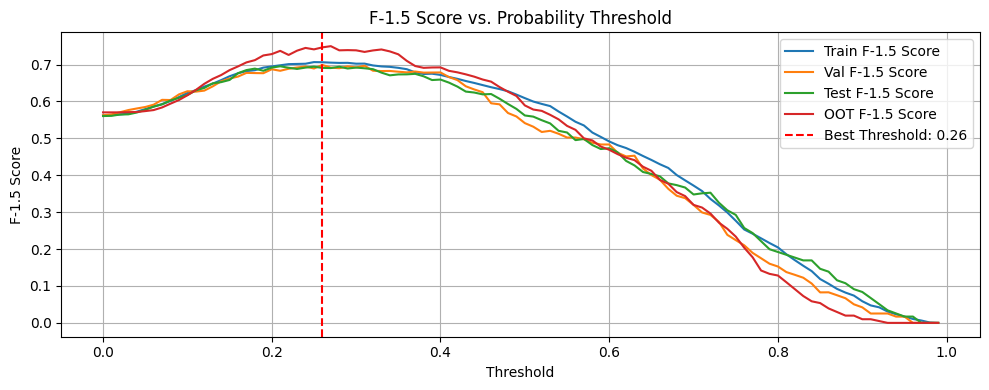

In [43]:
# F-B score across thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
beta = 1.5
f1_scores_train = [fbeta_score(y_train_arr, y_pred_proba_train > t, beta=beta) for t in thresholds]
f1_scores_val = [fbeta_score(y_val_arr, y_pred_proba_val > t, beta=beta) for t in thresholds]
f1_scores_test = [fbeta_score(y_test_arr, y_pred_proba_test > t, beta=beta) for t in thresholds]
f1_scores_oot = [fbeta_score(y_oot_arr, y_pred_proba_oot > t, beta=beta) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores_val)]

# Plot F1 Score vs. Threshold
plt.figure(figsize=(10, 4))
plt.plot(thresholds, f1_scores_train, label=f"Train F-{beta} Score")
plt.plot(thresholds, f1_scores_val, label=f"Val F-{beta} Score")
plt.plot(thresholds, f1_scores_test, label=f"Test F-{beta} Score")
plt.plot(thresholds, f1_scores_oot, label=f"OOT F-{beta} Score")
plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
plt.title(f"F-{beta} Score vs. Probability Threshold")
plt.xlabel("Threshold")
plt.ylabel(f"F-{beta} Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

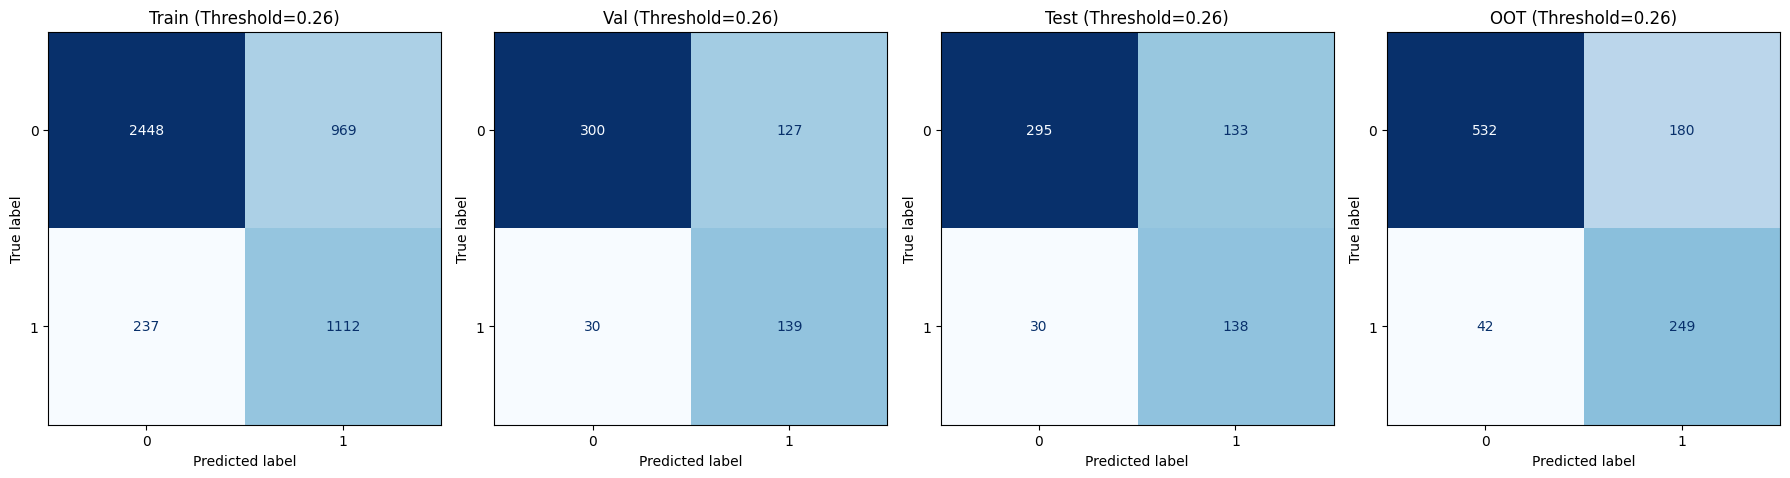

In [44]:
# Predictions
y_pred_train = (y_pred_proba_train > best_threshold).astype(int)
y_pred_val = (y_pred_proba_val > best_threshold).astype(int)
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)
y_pred_oot = (y_pred_proba_oot > best_threshold).astype(int)

# Confusion matrices
cm_train = confusion_matrix(y_train_arr, y_pred_train)
cm_val = confusion_matrix(y_val_arr, y_pred_val)
cm_test = confusion_matrix(y_test_arr, y_pred_test)
cm_oot = confusion_matrix(y_oot_arr, y_pred_oot)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

# Train
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(ax=axs[0], cmap='Blues', colorbar=False)
axs[0].set_title(f"Train (Threshold={best_threshold:.2f})")
axs[0].grid(False)

# Val
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(ax=axs[1], cmap='Blues', colorbar=False)
axs[1].set_title(f"Val (Threshold={best_threshold:.2f})")
axs[1].grid(False)

# Test
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axs[2], cmap='Blues', colorbar=False)
axs[2].set_title(f"Test (Threshold={best_threshold:.2f})")
axs[2].grid(False)

# OOT
disp_oot = ConfusionMatrixDisplay(confusion_matrix=cm_oot)
disp_oot.plot(ax=axs[3], cmap='Blues', colorbar=False)
axs[3].set_title(f"OOT (Threshold={best_threshold:.2f})")
axs[3].grid(False)

plt.tight_layout()
plt.show()

In [46]:
print(f"Best Train F{beta}-Score: {max(f1_scores_train):.4f}")
print(f"Best Val F{beta}-Score: {max(f1_scores_val):.4f}")
print(f"Best Test F{beta}-Score: {max(f1_scores_test):.4f}")
print(f"Best OOT F{beta}-Score: {max(f1_scores_oot):.4f}")

Best Train F1.5-Score: 0.7068
Best Val F1.5-Score: 0.6990
Best Test F1.5-Score: 0.6954
Best OOT F1.5-Score: 0.7499


# Training Pipeline with MLFlow

In [47]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://mlflow:5001")

# Create a new experiment for that training date
mlflow.set_experiment(config["model_train_date_str"])

2025/06/15 06:52:27 INFO mlflow.tracking.fluent: Experiment with name '2024-09-01' does not exist. Creating a new experiment.


<Experiment: artifact_location='/app/model_bank/2', creation_time=1749970347171, experiment_id='2', last_update_time=1749970347171, lifecycle_stage='active', name='2024-09-01', tags={}>

Train & hyperparameter tune model

In [48]:
best_score = -np.inf
best_model = None
best_params = {}
best_signature = None
best_input_example = None

########################
# Model Training
########################
for solver, penalty, C, max_iter in itertools.product(param_grid['solver'], param_grid['penalty'], param_grid['C'], param_grid['max_iter']):
    if penalty not in valid_combinations.get(solver, []):
        continue  # skip invalid combo

    # Start an MLflow run
    with mlflow.start_run(run_name=f"logreg_C={C:.4f}_penalty={penalty}_solver={solver}_max-iter={max_iter}"):
        try:
            ####################
            # Train Model
            ####################
            model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter)
            model.fit(X_train_arr, y_train_arr)

            ####################
            # Evaluate Metrics
            ####################

            # AUC
            y_pred_proba_train = model.predict_proba(X_train_arr)[:, 1]
            train_auc = roc_auc_score(y_train_arr, y_pred_proba_train)
            y_pred_proba_val = model.predict_proba(X_val_arr)[:, 1]
            val_auc = roc_auc_score(y_val_arr, y_pred_proba_val)

            # F1.5
            thresholds = np.arange(0.0, 1.0, 0.01)
            beta = 1.5
            fb_scores_train = [fbeta_score(y_train_arr, y_pred_proba_train > t, beta=beta) for t in thresholds]
            fb_scores_val = [fbeta_score(y_val_arr, y_pred_proba_val > t, beta=beta) for t in thresholds]
            best_threshold = thresholds[np.argmax(fb_scores_val)]

            train_fb_score = fb_scores_train[np.argmax(fb_scores_val)]
            val_fb_score = fb_scores_val[np.argmax(fb_scores_val)]

            ####################
            # Log to MLFlow
            ####################
            mlflow.log_param("C", C)
            mlflow.log_param("penalty", penalty)
            mlflow.log_param("solver", solver)
            mlflow.log_param("max_iter", max_iter)

            mlflow.log_metric("train_auc", train_auc)
            mlflow.log_metric("val_auc", val_auc)

            mlflow.log_metric(f"train_f{beta:.1f}_score", train_fb_score)
            mlflow.log_metric(f"val_f{beta:.1f}_score", val_fb_score)

            if val_auc > best_score:
                best_score = val_auc
                best_model = model
                best_params = {'C': C, 'penalty': penalty, 'solver': solver, 'max_iter': max_iter}
                best_signature = infer_signature(X_val_arr, model.predict_proba(X_val_arr))
                best_input_example = X_val_arr[:5]
        except Exception as e:
            print(f"Skipped C={C}, penalty={penalty}, solver={solver}: {e}")
            mlflow.end_run(status="FAILED")
            continue

🏃 View run logreg_C=0.0100_penalty=l2_solver=lbfgs_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/cb2cb4495c6049a9844a7451bde47781
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=0.1000_penalty=l2_solver=lbfgs_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/3b74787dbbd9484b889a3037ceeab83b
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=1.0000_penalty=l2_solver=lbfgs_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/d236cc863a654dfab059aa5d07e5a0e9
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=10.0000_penalty=l2_solver=lbfgs_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/3951643741584daf991b8564ce69c9f8
🧪 View experiment at: http://mlflow:5001/#/experiments/2


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=0.0100_penalty=None_solver=lbfgs_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/bf25bbfa25004ae69c0038b239cb30f8
🧪 View experiment at: http://mlflow:5001/#/experiments/2


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=0.1000_penalty=None_solver=lbfgs_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/f71c342729ee41e3b8a04d4af5bd388d
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=1.0000_penalty=None_solver=lbfgs_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/e40c285332654e2b9af2559c4ca42ef2
🧪 View experiment at: http://mlflow:5001/#/experiments/2


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=10.0000_penalty=None_solver=lbfgs_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/d72129e6c91e4492a64c35f46c09c13f
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=0.0100_penalty=l2_solver=newton-cg_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/a7aeb69efb314b1eae34be36eefb6cbe
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=0.1000_penalty=l2_solver=newton-cg_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/0d9a31f3cd184942aaae0c3390303776
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=1.0000_penalty=l2_solver=newton-cg_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/b8cb7d65b4a84e5a8826044512ac734f
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=10.0000_penalty=l2_solver=newton-cg_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/ef206056938c4d4e95df708f06c3818d
🧪 View experiment at: http://mlflow:5001/#/expe

/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=0.0100_penalty=None_solver=newton-cg_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/2081e678e0e642b882ecbd8617b69ad7
🧪 View experiment at: http://mlflow:5001/#/experiments/2


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=0.1000_penalty=None_solver=newton-cg_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/d4c542396c424dc8a76e8e2095d094dc
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=1.0000_penalty=None_solver=newton-cg_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/287bbf55216e4394ba5fed6c6ef981d6
🧪 View experiment at: http://mlflow:5001/#/experiments/2


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=10.0000_penalty=None_solver=newton-cg_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/2ca87144917b4da183bb2802d0bf8e6a
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=0.0100_penalty=l1_solver=liblinear_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/d31fe59278d94c3e93a65eea22bb8013
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=0.1000_penalty=l1_solver=liblinear_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/78b744a18de54e2193ff7cd812ba08ef
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=1.0000_penalty=l1_solver=liblinear_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/51d860bee6e64df491381e895e19d84e
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=10.0000_penalty=l1_solver=liblinear_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/ab75f7dbafd04e4a946a2adccb209d44
🧪 View experiment at: http://mlflow:5001/#/

/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=0.0100_penalty=None_solver=sag_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/dc2939b47fbc4324b032175d63cad4d0
🧪 View experiment at: http://mlflow:5001/#/experiments/2


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=0.1000_penalty=None_solver=sag_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/f6a6b86767604732ba07e62598035d4e
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=1.0000_penalty=None_solver=sag_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/3787a22a07ce401788c6a5213692e270
🧪 View experiment at: http://mlflow:5001/#/experiments/2


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=10.0000_penalty=None_solver=sag_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/831bd76145154bd794c21acbdc9c88fc
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=0.0100_penalty=l1_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/0c74217d7d43408581d620ae8ae6ecb5
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=0.1000_penalty=l1_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/edf5b981618049ceac9a0e8bda6f2df9
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=1.0000_penalty=l1_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/6eaf1e06cd1c420ab4c4b0e610e6cb8d
🧪 View experiment at: http://mlflow:5001/#/experiments/2


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🏃 View run logreg_C=10.0000_penalty=l1_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/7534b886cf1a452fbc3daae97cf90db0
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=0.0100_penalty=l2_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/85a42ff4ebee468a9b41b782b0db00e3
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=0.1000_penalty=l2_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/a1211d9e91084aea8b409e08b10b9324
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=1.0000_penalty=l2_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/f6782861d5984f8a8ab2d27ee2ab5d95
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=10.0000_penalty=l2_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/b5d21ce483744d7fadeb1a251651bb74
🧪 View experiment at: http://mlflow:5001/#/experiments/2
Skipped C=0.0

/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=0.0100_penalty=None_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/56f72af1606c4bc28f9a0664de11423c
🧪 View experiment at: http://mlflow:5001/#/experiments/2


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=0.1000_penalty=None_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/c32737e740204f46b1aa2bd229df3104
🧪 View experiment at: http://mlflow:5001/#/experiments/2
🏃 View run logreg_C=1.0000_penalty=None_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/026bf4f4e1964a348be2a6f2e898eeee
🧪 View experiment at: http://mlflow:5001/#/experiments/2


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run logreg_C=10.0000_penalty=None_solver=saga_max-iter=200 at: http://mlflow:5001/#/experiments/2/runs/784cb1c61ae64cb5b88f19173d405ec6
🧪 View experiment at: http://mlflow:5001/#/experiments/2


Save best model

In [49]:
with mlflow.start_run(run_name="best_model"):
    ####################
    # Evaluate Metrics
    ####################
    # AUC
    y_pred_proba_train = best_model.predict_proba(X_train_arr)[:, 1]
    train_auc = roc_auc_score(y_train_arr, y_pred_proba_train)
    y_pred_proba_val = best_model.predict_proba(X_val_arr)[:, 1]
    val_auc = roc_auc_score(y_val_arr, y_pred_proba_val)
    y_pred_proba_test = best_model.predict_proba(X_test_arr)[:, 1]
    test_auc = roc_auc_score(y_test_arr, y_pred_proba_test)
    y_pred_proba_oot = best_model.predict_proba(X_oot_arr)[:, 1]
    oot_auc = roc_auc_score(y_oot_arr, y_pred_proba_oot)

    # F1.5
    thresholds = np.arange(0.0, 1.0, 0.01)
    beta = 1.5
    fb_scores_train = [fbeta_score(y_train_arr, y_pred_proba_train > t, beta=beta) for t in thresholds]
    fb_scores_val = [fbeta_score(y_val_arr, y_pred_proba_val > t, beta=beta) for t in thresholds]
    fb_scores_test = [fbeta_score(y_test_arr, y_pred_proba_test > t, beta=beta) for t in thresholds]
    fb_scores_oot = [fbeta_score(y_oot_arr, y_pred_proba_oot > t, beta=beta) for t in thresholds]
    best_threshold = thresholds[np.argmax(fb_scores_val)]

    train_fb_score = fb_scores_train[np.argmax(fb_scores_val)]
    val_fb_score = fb_scores_val[np.argmax(fb_scores_val)]
    test_fb_score = fb_scores_train[np.argmax(fb_scores_test)]
    oot_fb_score = fb_scores_val[np.argmax(fb_scores_oot)]

    ####################
    # Log to MLFlow
    ####################
    
    # Params
    mlflow.log_params(config)
    mlflow.log_params(best_params)
    mlflow.log_param("best_fb_threshold", best_threshold)

    # AUC
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("val_auc", val_auc)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_metric("oot_auc", oot_auc)

    # F-Beta
    mlflow.log_metric(f"train_f{beta:.1f}_score", train_fb_score)
    mlflow.log_metric(f"val_f{beta:.1f}_score", val_fb_score)
    mlflow.log_metric(f"test_f{beta:.1f}_score", test_fb_score)
    mlflow.log_metric(f"oot_f{beta:.1f}_score", oot_fb_score)

    full_pipeline = make_pipeline(
        preprocessing_pipeline,
        best_model
    )

    model_info = mlflow.sklearn.log_model(
        sk_model=full_pipeline,
        artifact_path=f"{config['model_train_date_str']}",
        input_example=best_input_example,
        signature=best_signature,
        registered_model_name="creditkarma-scorer"
    )

    client = MlflowClient()

    client.set_model_version_tag(
        name="creditkarma-scorer",
        version=model_info.registered_model_version,
        key="train_date",
        value=config["model_train_date_str"]
    )

    print(f"✅ Logged and registered best model: {model_info.model_uri}")

Registered model 'creditkarma-scorer' already exists. Creating a new version of this model...
2025/06/15 06:53:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: creditkarma-scorer, version 2
Created version '2' of model 'creditkarma-scorer'.


✅ Logged and registered best model: runs:/ab85f2fcc3af4d95b1bf893dabb759a2/2024-09-01
🏃 View run best_model at: http://mlflow:5001/#/experiments/2/runs/ab85f2fcc3af4d95b1bf893dabb759a2
🧪 View experiment at: http://mlflow:5001/#/experiments/2


Pick best model for production

In [ ]:
# metrics_to_compare = ["test_f1.5_score", "oot_f1.5_score"]

# def scoring_fn(metrics):
#     """
#     Weighted average of performance and stability metrics
#     """
#     try:
#         return (
#             0.6 * metrics["test_f1.5_score"] +
#             0.4 * metrics["oot_f1.5_score"]
#         )
#     except KeyError:
#         return float("-inf")  # skip models missing metrics

# best_version = None
# best_score = float("-inf")

# for v in client.search_model_versions(f"name='creditkarma-scorer'"):
#     run_id = v.run_id
#     run_metrics = client.get_run(run_id).data.metrics

#     # Make sure all required metrics are present
#     if all(m in run_metrics for m in metrics_to_compare):
#         score = scoring_fn(run_metrics)
#         if score > best_score:
#             best_score = score
#             best_version = v

# if best_version:
#     client.set_registered_model_alias("creditkarma-scorer", "champion", best_version.version)
#     print(f"✅ Deployed version {best_version.version} with composite score {best_score:.4f}")
# else:
#     print("❌ No suitable model version found.")

✅ Deployed version 2 with composite score 0.7090
